/var/folders/ct/dqdky4352zx_f2qfwpf8xq840000gn/T/ipykernel_18957/2313201619.py:101: UserWarning: The init module will be deprecated soon, since templates can now provide a method that returns the shape of parameter tensors.
  weights_init = strong_ent_layers_uniform(num_layers, num_qubits, seed=42)
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.3511897 | Acc train: 0.3541667 | Acc validation: 0.2000000 
Iter:     2 | Cost: 0.3736590 | Acc train: 0.3916667 | Acc validation: 0.2833333 
Iter:     3 | Cost: 0.3500556 | Acc train: 0.4000000 | Acc validation: 0.3166667 
Iter:     4 | Cost: 0.5603095 | Acc train: 0.4541667 | Acc validation: 0.3666667 
Iter:     5 | Cost: 0.3670581 | Acc train: 0.4708333 | Acc validation: 0.3833333 
Iter:     6 | Cost: 0.2561992 | Acc train: 0.4708333 | Acc validation: 0.3833333 
Iter:     7 | Cost: 0.3053967 | Acc train: 0.4750000 | Acc validation: 0.3833333 
Iter:     8 | Cost: 0.2933577 | Acc train: 0.4833333 | Acc validation: 0.3833333 
Iter:     9 | Cost: 0.3309552 | Acc train: 0.4875000 | Acc validation: 0.3833333 
Iter:    10 | Cost: 0.1744920 | Acc train: 0.4958333 | Acc validation: 0.3833333 


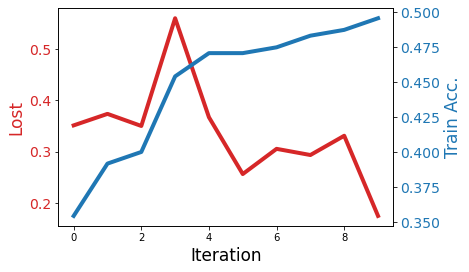

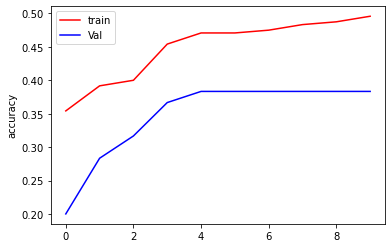

[[ 0  0  0]
 [ 1  0 36]
 [ 0  0 23]]


In [1]:
#-----------QOSF Sceening Task 2 solution - Vedant Dwivedi 

#-----------------Imports

import pennylane as qml

from pennylane import numpy as np
from pennylane.templates.embeddings import AmplitudeEmbedding, AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.optimize import NesterovMomentumOptimizer , GradientDescentOptimizer, AdamOptimizer
from pennylane.init import strong_ent_layers_uniform
import torch
from torch.autograd import Variable
from sklearn.preprocessing import minmax_scale
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

#-------------Training Data import, preprocessing and splitting

# load the training dataset
data_train=np.loadtxt('/Users/apple/variational_classifer/data/mock_train_set.csv', delimiter=',', skiprows=1)

# uses the column 4  as the target and use the data from column0 to column3 
X = data_train[:, 0:4]
y = data_train[:,4]


# normalize data
X = minmax_scale(X, feature_range=(0, np.pi))

feature_size= X.shape[1]
batch_size = 20
num_qubits = feature_size
num_layers = 5
num_data = len(y)
num_train = int(0.80 * num_data)

#split into train and validation
np.random.seed(0)
index = np.random.permutation(range(num_data))

X_train = X[index[:num_train]]
y_train = y[index[:num_train]]
X_val = X[index[num_train:]]
y_val = y[index[num_train:]]

#-----------------Building the quantum classifier

# quantum device handle
dev = qml.device("default.qubit", wires=num_qubits)

#def layer(W):
 #   for i in range(num_qubits):
  #      qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
   # for j in range(num_qubits - 1):
    #    qml.CNOT(wires=[j, j + 1])
    #if num_qubits >= 2:
     #   # Apply additional CNOT to entangle the last with the first qubit
      #  qml.CNOT(wires=[num_qubits - 1, 0])

@qml.qnode(dev)
def circuit(weights, x=None):
    qml.templates.AngleEmbedding(x, wires=range(num_qubits),rotation='Y')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits),imprimitive=qml.CZ)
   #for W in weights:
    #    layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x=None):
    return circuit(weights, x=x) + bias

def cost(weights, bias, X, expectations):
    e_predicted = [variational_classifier(weights, bias, x=x) for x in X]
    return square_loss(expectations,e_predicted)

def square_loss(expectations, e_predicted):
    loss = 0
    for l, p in zip(expectations, e_predicted):
        loss = loss + (l - p) ** 2

    loss = loss / len(expectations)
    return loss

def accuracy(expectations, e_predicted):

    loss = 0
    for l, p in zip(expectations, e_predicted):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(expectations)

    return loss

#----------------------Training and Inference

#draw random quantum node weights----------
#weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
#bias_init = np.array(0.0, requires_grad=True)

#draw random quantum node weights----------
weights_init = strong_ent_layers_uniform(num_layers, num_qubits, seed=42)
bias_init = 0.0
weights = weights_init
bias = bias_init

#build the optimizer object-------------------
#opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)
#opt = NesterovMomentumOptimizer(0.1)
opt = GradientDescentOptimizer(0.1)

lossplot = []
train_acc, train_val_acc = [], []
for it in range(10):

    #Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
    
    # Compute predictions on train, validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, x=x)) for x in X_train]
    predictions_val =  [np.sign(variational_classifier(weights, bias, x=x)) for x in X_val]


    # Compute accuracy on train, validation set
    acc_train = accuracy(y_train, predictions_train)
    acc_val = accuracy(y_val, predictions_val)

    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, X_batch, Y_batch), acc_train, acc_val))
    lossplot.append(cost(weights, bias, X_batch, Y_batch))
    train_acc.append(acc_train)
    train_val_acc.append(acc_val)

fig, ax1 = plt.subplots()
iters = np.arange(0, 10, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Lost", fontsize=17, color=colors[0])
ax1.plot(iters, lossplot, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Train Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, train_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)

plt.show()

plt.plot(train_acc,'r',label="train")
plt.plot(train_val_acc,'b',label="Val")
plt.ylabel('accuracy')
plt.legend()
plt.show()


print(metrics.confusion_matrix(y_val,predictions_val))


/var/folders/ct/dqdky4352zx_f2qfwpf8xq840000gn/T/ipykernel_18957/690074053.py:85: UserWarning: The init module will be deprecated soon, since templates can now provide a method that returns the shape of parameter tensors.
  weights_init = strong_ent_layers_uniform(num_layers, num_qubits, seed=42)
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.5580158 | Acc train: 0.3229167 | Acc validation: 0.4583333 
Iter:     2 | Cost: 0.4487502 | Acc train: 0.3437500 | Acc validation: 0.5000000 
Iter:     3 | Cost: 0.4524426 | Acc train: 0.3854167 | Acc validation: 0.5416667 
Iter:     4 | Cost: 0.3561934 | Acc train: 0.3958333 | Acc validation: 0.5416667 
Iter:     5 | Cost: 0.1826438 | Acc train: 0.4062500 | Acc validation: 0.5416667 
Iter:     6 | Cost: 0.3082319 | Acc train: 0.4270833 | Acc validation: 0.5416667 
Iter:     7 | Cost: 0.3788862 | Acc train: 0.4479167 | Acc validation: 0.5416667 
Iter:     8 | Cost: 0.3189663 | Acc train: 0.4375000 | Acc validation: 0.5416667 
Iter:     9 | Cost: 0.3247004 | Acc train: 0.4583333 | Acc validation: 0.6250000 
Iter:    10 | Cost: 0.2545523 | Acc train: 0.4791667 | Acc validation: 0.6250000 


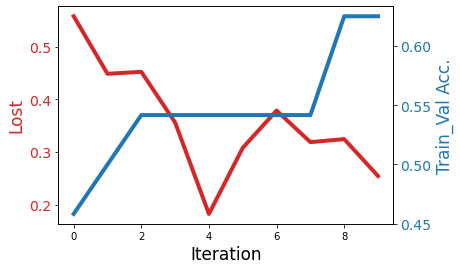

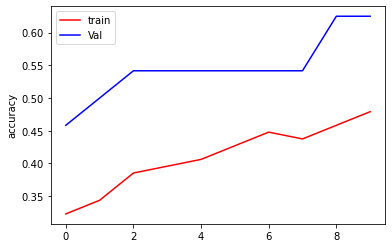

[[ 0  9]
 [ 0 15]]


In [2]:
#---------------Testing Data import, preprocessing and splitting

# load the testing dataset
data_test=np.loadtxt('/Users/apple/variational_classifer/data/mock_test_set.csv', delimiter=',', skiprows=1)

# uses the column 4  as the target and use the data from column0 to column3 
X = data_test[:, 0:4]
y = data_test[:,4]


# normalize data
X = minmax_scale(X, feature_range=(0, np.pi))


feature_size= X.shape[1]
batch_size = 20
num_qubits = feature_size
num_layers = 5
num_data = len(y)
num_train = int(0.80 * num_data)

#split into train and validation
np.random.seed(0)
index = np.random.permutation(range(num_data))

X_train = X[index[:num_train]]
y_train = y[index[:num_train]]
X_val = X[index[num_train:]]
y_val = y[index[num_train:]]

#-----------------------Building the quantum classifier

# quantum device handle
dev = qml.device("default.qubit", wires=num_qubits)

#def layer(W):
 #   for i in range(num_qubits):
  #      qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
   # for j in range(num_qubits - 1):
    #    qml.CNOT(wires=[j, j + 1])
    #if num_qubits >= 2:
     #   # Apply additional CNOT to entangle the last with the first qubit
      #  qml.CNOT(wires=[num_qubits - 1, 0])

@qml.qnode(dev)
def circuit(weights, x=None):
    qml.templates.AngleEmbedding(x, wires=range(num_qubits),rotation='Y')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits),imprimitive=qml.CZ)
   #for W in weights:
    #    layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x=None):
    return circuit(weights, x=x) + bias

def cost(weights, bias, X, expectations):
    e_predicted = [variational_classifier(weights, bias, x=x) for x in X]
    return square_loss(expectations,e_predicted)

def square_loss(expectations, e_predicted):
    loss = 0
    for l, p in zip(expectations, e_predicted):
        loss = loss + (l - p) ** 2

    loss = loss / len(expectations)
    return loss

def accuracy(expectations, e_predicted):

    loss = 0
    for l, p in zip(expectations, e_predicted):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(expectations)

    return loss

#------------------------Training and Inference

#draw random quantum node weights----------
#weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
#bias_init = np.array(0.0, requires_grad=True)

#draw random quantum node weights----------
weights_init = strong_ent_layers_uniform(num_layers, num_qubits, seed=42)
bias_init = 0.0
weights = weights_init
bias = bias_init

#build the optimizer object-------------------
#opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)
#opt = NesterovMomentumOptimizer(0.2)
opt = GradientDescentOptimizer(0.1)

lossplot = []
train_acc, train_val_acc, test_acc = [], [], []
for it in range(10):

    #Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
    
    # Compute predictions on train, validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, x=x)) for x in X_train]
    predictions_val =  [np.sign(variational_classifier(weights, bias, x=x)) for x in X_val]


    # Compute accuracy on train, validation
    acc_train = accuracy(y_train, predictions_train)
    acc_val = accuracy(y_val, predictions_val)


    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, X_batch, Y_batch), acc_train, acc_val))
    lossplot.append(cost(weights, bias, X_batch, Y_batch))
    train_acc.append(acc_train)
    train_val_acc.append(acc_val)

fig, ax1 = plt.subplots()
iters = np.arange(0, 10, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Lost", fontsize=17, color=colors[0])
ax1.plot(iters, lossplot, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Train_Val Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, train_val_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)

plt.show()

plt.plot(train_acc,'r',label="train")
plt.plot(train_val_acc,'b',label="Val")
plt.ylabel('accuracy')
plt.legend()
plt.show()


print(metrics.confusion_matrix(y_val,predictions_val))